# Notebook 2: Persistence of grayscale images
In this notebook we'll use `gudhi` to compute sublevel set filtrations. As an example application, we'll build sublevel set filtrations from grayscale images. The persistent homology of these filtrations summarizes the patterns of dark and light in these images and can help us tell different kinds of images apart.

This Notebook has **two compulsory Exercises.** 

In [1]:
!pip install gudhi

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import networkx as nx
import gudhi
import os

This next bit of code is just to check that the data is in the same folder as this notebook.

In [5]:
if os.path.exists('tda-texture-exercise'):
    print('The data is in the correct folder. Continue!')
else:
    print('Can\'t find the data, please copy the folder tda-texture-exercise into your home directory')

The data is in the correct folder. Continue!


## Looking at the data
Our dataset contains images of various textures. An important problem in computer vision is to be able to tell textures like these apart (say for processing satellite images). Let's take a look at one of the images in the dataset.

In [7]:
#loads one image
im = Image.open("tda-texture-exercise/grasshe.tiff")

Grayscale images like these are actually really simple. To a computer, they are just 2D arrays of numbers indicating the pixel color. Grayscale images have pixel values between 0 (black) and 255 (white). We can turn our image into an array of numbers like this:

In [8]:
imarray = np.array(im)

Let's look at this array.

In [9]:
imarray

array([[  7,   9,  16, ..., 189, 144,  35],
       [ 11,   2,   4, ..., 182, 144,  31],
       [ 45,  54,  11, ..., 165, 130, 109],
       ...,
       [ 29, 158, 130, ..., 117,  49,  11],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

To turn the array back into an image, we can use `imshow`. The argument `cmap` tells the display how to convert the number into a color.

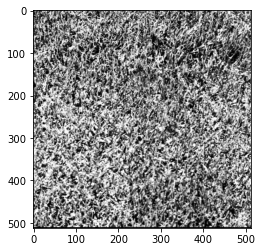

In [10]:
plt.imshow(imarray, cmap='gray')

## Turning an image into a cubical complex with a filter function.

We need to turn our image into a cubical complex with a filter function. For our filter function, we'll use the pixel values. Let's demonstrate this on one piece of the image above. Since the image is just an array (i.e. matrix now), we can grab the top-left corner by asking for the $(i,j)$ entries with $i < P$ and $j < Q$ for some values of $P$ and $Q$.

_Syntax_: If M is a matrix, `M[a:b,c:d]` pulls out the entries $(i,j)$ where $a \leq i < b$ and $c \leq j < d$. Everything is indexed from zero as always in Python!

We'll pull out a particular small piece of the above image so we can see the persistent homology in action.

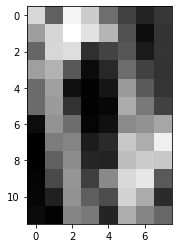

In [11]:
#get a piece of the top left corner of the grass image -- see Syntax above
piece = imarray[0:12,4:12]
plt.imshow(piece, cmap='gray')

Our goal is to turn the image above into a cubical complex with a filtration function on the cubes. Each pixel is going to be a square, that is, a 2-cube. 
Fortunately, `gudhi` has an object type specifically designed to handle images like these that automatically builds this cube complex. We need to tell it (a) what the dimensions of our grid are and (b) what the filtration values should be.

When choosing filtration values, we have two natural choices:
- assign higher values to lighter pixels
- assign higher values to darker pixels

Since it's slightly easier to visualize, we'll do the second one. This means that we want the filter value of a pixel to be $255 - x$, where $x$ is the pixel value in the image (remember that higher pixel values mean brighter in our array). Thus we want to work with this array:

In [12]:
255 - piece

array([[ 47, 158,  19,  57, 145, 187, 213, 196],
       [101,  49,   9,  37,  79, 173, 235, 200],
       [152,  47,  40, 204, 185, 167, 223, 199],
       [ 99,  81, 165, 237, 209, 146, 186, 200],
       [148,  99, 233, 245, 227, 104, 164, 198],
       [148, 104, 200, 246, 241,  88, 135, 187],
       [236, 110, 146, 243, 233, 118, 111,  93],
       [247, 132, 123, 221, 208,  61,  86,  24],
       [248, 157, 116, 212, 215,  70,  57,  61],
       [244, 178, 108, 189, 120,  45,  32, 164],
       [242, 218, 111, 160, 176,  50,  88, 207],
       [237, 246, 122, 135, 213,  86, 123, 151]], dtype=uint8)

If you got a bit confused with this switch, just look at the array above and convince yourself the the low numbers represent bright spots in the image above.

Now we are ready to build our cubical complex. The constructor `cubeComplex` takes two arguments:
- `dimensions`: A pair containing width and height of our image
- `top_dimensional_cells`: The filtration values of the highest dimension cubes (in our case squares). This has to be a 1D array no matter what the dimension, so we use the Python function `flatten()` to turn our array into a list of numbers.

In [20]:
height, width = piece.shape
cubeComplex = gudhi.CubicalComplex(
    dimensions = [width,height],
    top_dimensional_cells = 255 - piece.flatten()
)

Just for fun, let's see how many cubes (of all dimensions!) are in this cubical complex. Do you understand where this number comes from? Hint: you need all the squares, then all the sides of those squares, and all the corners. 

In [21]:
cubeComplex.num_simplices()

425

## Time to compute persistent homology
`gudhi` calculates persistence for you, so all we have to do is call the `compute_persistence()` function like this.

In [22]:
cubeComplex.compute_persistence()

In order to extract the persistence diagrams, we need to tell `gudhi` which dimension we want. Let's do dimension 0 (connected components) first.

In [23]:
H0 = cubeComplex.persistence_intervals_in_dimension(0)

In [24]:
H0

array([[ 47.,  49.],
       [ 32.,  57.],
       [ 88., 111.],
       [108., 123.],
       [ 24., 160.],
       [196., 200.],
       [  9.,  inf]])

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

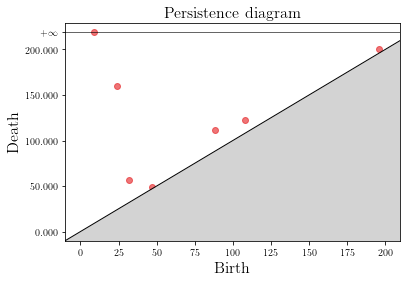

In [25]:
gudhi.plot_persistence_diagram(persistence=H0)

Take a look at this persistence diagram and look at the picture of the patch above, and decide whether it makes sense to you. High persistence points represent bright clusters of pixels. Do you see the two bright clusters?

Now let's do dimension 1.

In [26]:
H1 = cubeComplex.persistence_intervals_in_dimension(1)

In [27]:
H1

array([[212., 215.],
       [213., 235.],
       [167., 246.]])

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

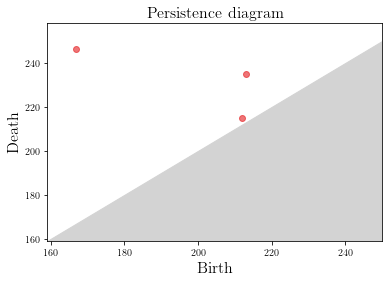

In [28]:
gudhi.plot_persistence_diagram(persistence=H1)

High persistence points here represent loops of bright pixels with darker pixels inside. Can you see the most prominent loop in the image?

## Exercise 1: persistence of `sandhe.png`
In the blocks below, write code to display the 0-dimensional and 1-dimensional persistent homology for the top-left 100x100 corner of the image `sandhe.png`. Reuse as much of the above code as you like.

## Exercise 2: flipping the filter function
We chose to make the filter function equal to $255- $ the pixel value, so brighter pixels have lower filter values than whiter ones. But we can also try the opposite. In the code blocks below, repeat Exercise 1, except this time flip the filter values so that whiter pixels have higher filter values and blacker pixels have lower filter values. 

_Side note_: in [this](https://openaccess.thecvf.com/content_CVPRW_2020/html/w50/Chung_Smooth_Summaries_of_Persistence_Diagrams_and_Texture_Classification_CVPRW_2020_paper.html) paper (by researchers here at UNCG!), the authors use both versions (brighter and darker) just to be sure.

# Challenge questions

- Use the `gudhi` functions [here](https://gudhi.inria.fr/python/latest/representations.html) and display the 0- and 1-dimensional persistence image for the top left hand corner of `sandhe.png`.
- Use the `gudhi` functions [here](https://gudhi.inria.fr/python/latest/representations.html) and display the 0- and 1-dimensional persistence landscapes (just the first two landscapes is enough) for the top left hand corner of `sandhe.png`.
- Compare the persistence images and landscapes of the top left corner of `sandhe.png` and the bottom right corner of the same image. Do they look similar or different (open ended question).